# Applied Data Visualization – Homework 2
*https://www.dataviscourse.net/2024-applied/*


In this homework we will further explore the avalanche data by creating custom charts in Matplotlib. 

**Note that you may only use Matplotlib for this homework; no other charting libraries like Seaborn!**

## Your Info and Submission Instructions

* *First name: Logan*
* *Last name: Correa*
* *Email: u1094034@umail.utah.edu*
* *UID: u1094034*



For your submission, please do the following things: 
* **rename the file to `hw2_lastname.pynb`**
* **include all files that you need to run the homework, including the data file provided** 
* **don't use absolute paths, but use a relative path to the same directory for referencing data**

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime


plt.style.use('default')
# This next line tells jupyter to render the images inline
%matplotlib inline
import matplotlib_inline
# This renders your figures as vector graphics AND gives you an option to download a PDF too
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

## Read & Clean up the Data

You've already done data cleanup in the previous homework, so we'll provide this for you. 

In [182]:
avy_df = pd.read_csv('./avalanches.csv')

# Clean dates and elevation
avy_df['Date'] = pd.to_datetime(avy_df['Date'])
avy_df['Year'] = avy_df['Date'].dt.year.astype('Int64')
avy_df['Month'] = avy_df['Date'].dt.month.astype('Int64')
avy_df['Elevation_Feet'] = pd.to_numeric(avy_df['Elevation'].str.replace('\'', '').str.replace(',', ''))

# Filter out null dates and incomplete years
avy_df = avy_df[avy_df['Date']==avy_df['Date']]
avy_df = avy_df[avy_df['Year'] > 2009]

# Part 1: Violin Plot Per Region

* Create a horizontal violin plot of distributions of avalanche elevations by Region.  
* Sort the regions by the median avalanche elevation in a descending order. 
* Plot the mean on the violing plot. 
* Create lables for the regions that also show the number of avalances in the region. For example: "Salt Lake (3654)"
* Analyze the data. What are trends you see? 

Hints: 
* you'll need to create a series of elevation values for each region 
* Matplotlib violinplots don't like NAN values, make sure to drop them before you try to plot

You can choose your own aesthetics, but make sure it looks good. 

For your reference, here is our solution: 

![Example](violinplot.svg)

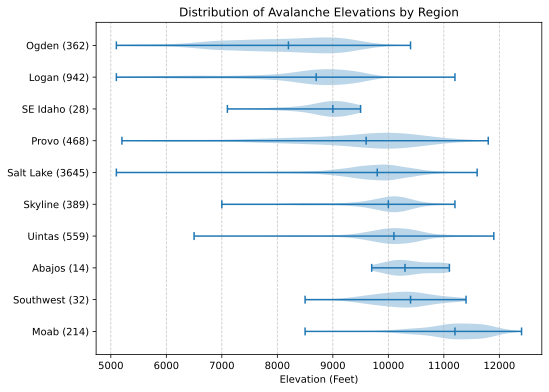

In [183]:
# Filter out Nan values
avy_filtered = avy_df.dropna(subset=['Elevation_Feet'])

# group by region sorted by median elevation
sorted_regions = avy_filtered.groupby('Region')['Elevation_Feet'].median().sort_values(ascending=False).index

# create list of elevation data for each region
elevation_data = [avy_filtered[avy_filtered['Region'] == region]['Elevation_Feet'] for region in sorted_regions]

# create labels for regions with number of avalances
region_labels = region_labels = [f"{region} ({len(avy_filtered[avy_filtered['Region'] == region])})" for region in sorted_regions]

# create horizontal violin plot
plt.figure(figsize=(8, 6))
violins = plt.violinplot(elevation_data, vert=False, showmedians=True)

# Labels and title
plt.yticks(range(1, len(region_labels) + 1), region_labels)
plt.xlabel('Elevation (Feet)')
plt.title('Distribution of Avalanche Elevations by Region')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.show()


### Your Analysis: 

Most regions have avalanche activity between 7,000 and 11,000 feet. Warmer locations such as Moab and Abajos have tighter distributions, suggesting that these areas have a narrower elevation range with more consistant snowpack conditions.


# Part 2: Radial Bar Chart

* Create a radial bar chart of the average number of avalanches in a year by Aspect.
* Arrange the aspects in the usual convention (North at the top, West on the left, etc.).
* Color the barchart using a cyclic colormap (e.g., HSV).
* Provide an analysis.

Hints: 
* Here is some useful reading: [https://matplotlib.org/stable/api/projections/polar.html](https://matplotlib.org/stable/api/projections/polar.html)

Here is our solution: 

![A radial visualization of avalanches per aspect](radial.svg)

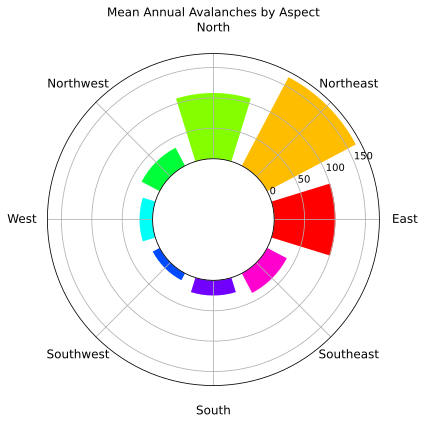

In [184]:
# Group by Aspect and count number of avalanches per year
aspect_counts = avy_df.groupby(['Aspect', 'Year']).size().unstack(fill_value=0).mean(axis=1)

# Define aspects in the desired order
#aspects_order = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
aspects_order = ["East", "Northeast", "North", "Northwest", "West", "Southwest", "South", "Southeast"]
aspect_counts = aspect_counts.reindex(aspects_order)

# Create radial bar chart
angles = np.linspace(0, 2 * np.pi, len(aspects_order), endpoint=False).tolist()
aspect_counts = pd.Series(aspect_counts.values, index=angles)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
bars = ax.bar(
    aspect_counts.index, 
    aspect_counts.values, 
    width=0.6, 
    color=plt.cm.hsv(np.linspace(0, 1, len(aspects_order)+1))
)

# Set the labels for each bar
ax.set_yticks([0, 50, 100, 150])
ax.set_yticklabels(['0', '50', '100', '150'])
ax.set_xticks(angles)
ax.set_xticklabels(aspects_order, fontsize=12)
ax.tick_params(axis='x', pad=15)
ax.set_rorigin(-100)

ax.set_title('Mean Annual Avalanches by Aspect')
plt.show()

### Your Analysis: 

The majority of avalanches occur on slopes with aspects facing North, Northeast, and East; with the most being Northeast. Snowcover changes in aspect due to differences in exposure to the sun, which could lead to varying stability in the snowpack in areas that recieve more sunlight.

# Part 3: Rolling average area subplots

* Create a chart where each subfigure is an area chart of the 7-day rolling average of the number of avalanches in a given ski season. Assume that a "ski season" starts July 1 and ends June 31.
* The subplots should overlap so that outliers are less of a problem.
* Provide an analysis of the data. 

Useful methods to consider: 
- Pandas's `.rolling()`
- matplotlib's `.fill_between()`, `.set_axis_off()`, `.tight_layout()`
- datetime's `.timetuple().tm_yday`

Make sure to check out the arguments of the above methods.

Here's how your result should look: 

![A series of line charts showing avalanches over time](line.svg)

In [185]:
# Set the start and end dates for each ski season
avy_df['Ski_Season'] = avy_df['Date'].apply(lambda x: f"{x.year}/{str(x.year + 1)[-2:]}" if x.month >= 7 else f"{x.year - 1}/{str(x.year)[-2:]}")

# Group by ski season and calculate the number of avalanches per day
avy_per_day = avy_df.groupby(['Ski_Season', 'Date']).size().reset_index(name='Avalanche_Count')

# Calculate the rolling 7-day average of avalanche count per ski season
avy_per_day['Rolling_7_Day_Avg'] = avy_per_day.groupby('Ski_Season')['Avalanche_Count'].transform(lambda x: x.rolling(7, min_periods=1).mean())
avy_per_day = avy_per_day.drop(columns=['Avalanche_Count'])

# send to csv
avy_per_day.to_csv('./avalanches_per_day.csv', index=False)


/tmp/ipykernel_2499/1834293266.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])


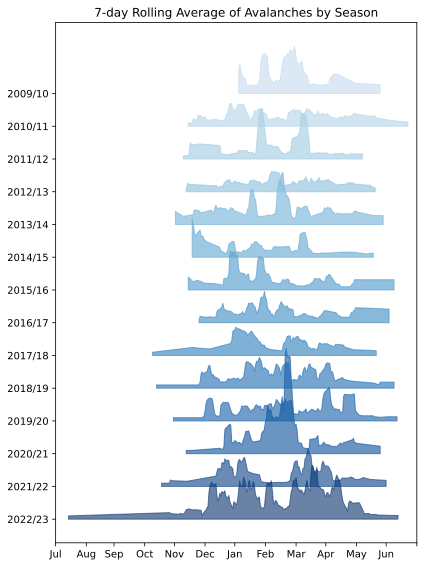

In [186]:
import matplotlib.dates as mdates

# Calculate 'Day_of_Year' for each date in the ski season
avy_per_day['Day_of_Year'] = avy_per_day['Date'].dt.dayofyear

# Adjust 'Day_of_Year' to start in July
avy_per_day['Adjusted_Day_of_Year'] = avy_per_day['Date'].apply(
    lambda x: (x - pd.Timestamp(x.year if x.month >= 7 else x.year - 1, 7, 1)).days + 1
)

# Sort by adjusted day of year for proper plotting
avy_per_day = avy_per_day.sort_values('Adjusted_Day_of_Year')

# Create the figure and axis for plotting
fig, ax = plt.subplots(figsize=(6, 8))

# Set colormap for varying shades
cmap = plt.cm.Blues

# Sort seasons to ensure plotting order
seasons_sorted = sorted(avy_per_day['Ski_Season'].unique(), reverse=True)

# Plot each ski season as a separate area chart
for i, season in enumerate(seasons_sorted):
    season_data = avy_per_day[avy_per_day['Ski_Season'] == season]
    season_data = season_data.sort_values('Adjusted_Day_of_Year')
    # Normalize the y position
    y_offset = i * 10  # Vertical offset for each season
    
    # Use .fill_between() to create an area chart with some transparency
    ax.fill_between(
        season_data['Adjusted_Day_of_Year'],  # Using 'Days_from_Start'
        season_data['Rolling_7_Day_Avg'] + y_offset,
        y_offset,
        color=cmap(1-(0.8 * (i / len(seasons_sorted)))),  # Adjust color gradient based on the index
        alpha=0.6,
        label=season
    )

# format axis
ax.set_xlim(0, 365)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xticklabels(['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
ax.set_yticks([i * 10 for i in range(len(seasons_sorted))])
ax.set_yticklabels(seasons_sorted)
plt.title('7-day Rolling Average of Avalanches by Season')
plt.tight_layout()
plt.show()

### Your Analysis: 

For most seasons, the risk of avalanches is greater during January through March. There is a sharp peak during the 2020/21 ski season which could indicate a significant weather event or instability in snowpack which could lead to increased avalanche risk.